# Denoising by proximal solvers - as in Chambolle paper

We try to solve the following problem (as in Pock and Chambolle paper):

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{u-f}||_2^2 + J(\mathbf{u})
$$

with different choices of regularization:

- L2 on Gradient $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_2^2$
- Anisotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1$
- Anisotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1 - \mathbf{p}_k^T \mathbf{u}$
- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$
- Isotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1} - \mathbf{p}_k^T \mathbf{u}$

Finally we compare the convergence properties of the Primal-Dual algorithm with the adaptive Primal-Dual algorithm of Goldstein - we can see how the latter converges faster to the solution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from skimage.data import camera
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

In [2]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [3]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 30
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

#img = img/255
#noise_img = noise_img/255

In [4]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 on Gradient

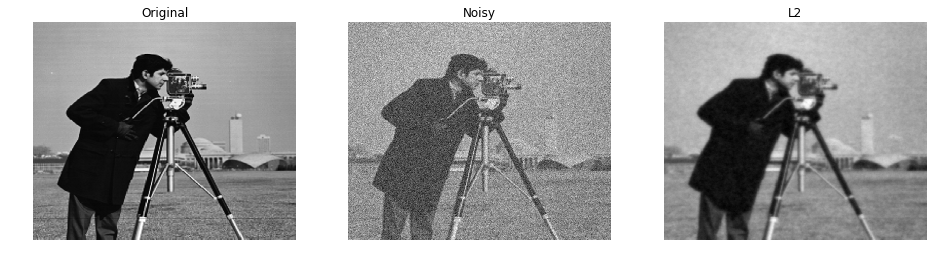

In [5]:
# L2 data term
lamda = .1
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L2 regularization
thik = L2()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml2 = LinearizedADMM(l2, thik, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml2 = iml2.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray')
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2, cmap='gray')
axs[2].set_title('L2')
axs[2].axis('off')
axs[2].axis('tight');

### Anisotropic TV

In [6]:
# L2 data term
lamda = 0.01
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 10. / np.sqrt(L)
mu = tau / L

iml1 = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, 
                      x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml1 = iml1.reshape(img.shape)

### Anisotropic TV + Bregman iterations

In [7]:
# L2 data term
lamda = .001
l2 = L2(b=noise_img.ravel(), sigma=lamda, qgrad=False)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 10. / np.sqrt(L)
mu = tau / L

iml1b = Bregman(l2, l1, A=Gop, x0=np.zeros_like(img.ravel()), 
                solver=LinearizedADMM, niterouter=10, show=True,
                **dict(tau=tau, mu=mu, niter=50))
iml1b = iml1b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function LinearizedADMM at 0x1a2069a730>
alpha = 1.000000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   3.39184e+00   2.364e+06   7.326e+03   2.372e+06
     2   6.70941e+00   2.271e+06   1.579e+04   2.287e+06
     3   9.95434e+00   2.181e+06   2.566e+04   2.207e+06
     4   1.31282e+01   2.094e+06   3.651e+04   2.130e+06
     5   1.62326e+01   2.010e+06   4.827e+04   2.058e+06
     6   1.92690e+01   1.929e+06   6.090e+04   1.990e+06
     7   2.22389e+01   1.852e+06   7.440e+04   1.926e+06
     8   2.51438e+01   1.778e+06   8.851e+04   1.866e+06
     9   2.79851e+01   1.707e+06   1.031e+05   1.810e+06
    10   3.07642e+01   1.639e+06   1.183e+05   1.7

### Isotropic TV with Primal-Dual

In [8]:
# L2 data term
lamda = .01
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                   x0=np.zeros_like(img.ravel()), 
                   niter=100, show=True)
iml12 = iml12.reshape(img.shape)

iml12_1 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                     x0=np.zeros_like(img.ravel()), gfirst=False,
                     niter=100, show=True)
iml12_1 = iml12_1.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.535534e-01	mu = 3.535534e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   4.95707e-01   2.443e+07   4.964e+04   0.000e+00       2.448e+07
     2   1.00605e+00   2.426e+07   4.630e+04   0.000e+00       2.431e+07
     3   1.54323e+00   2.411e+07   3.834e+04   0.000e+00       2.414e+07
     4   2.10743e+00   2.395e+07   3.392e+04   0.000e+00       2.398e+07
     5   2.69392e+00   2.379e+07   3.285e+04   0.000e+00       2.382e+07
     6   3.29757e+00   2.364e+07   3.257e+04   0.000e+00       2.367e+07
     7   3.91140e+00   2.348e+07   3.239e+04   0.000e+00       2.351e+07
     8   4.52551e+00   2.333e+07   3

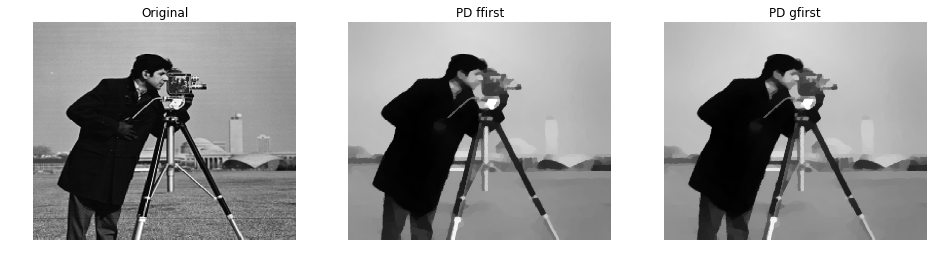

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(iml12, cmap='gray')
axs[1].set_title('PD ffirst')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml12_1, cmap='gray')
axs[2].set_title('PD gfirst')
axs[2].axis('off')
axs[2].axis('tight');

### Isotropic TV + Bregman iterations

In [10]:
lamda = 0.001
l2 = L2(b=noise_img.ravel(), sigma=lamda, qgrad=False)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 0.01
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12b = Bregman(l2, l1iso, A=Gop, x0=np.zeros_like(img.ravel()), 
                 solver=PrimalDual, niterouter=10, show=True,
                 **dict(tau=tau, mu=mu, theta=1., niter=50))
iml12b = iml12b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x1a2069a7b8>
alpha = 1.000000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   2.71958e+00   2.383e+06   4.700e+03   2.388e+06
     2   5.39141e+00   2.307e+06   1.051e+04   2.318e+06
     3   8.01633e+00   2.233e+06   1.731e+04   2.250e+06
     4   1.05952e+01   2.161e+06   2.491e+04   2.186e+06
     5   1.31287e+01   2.091e+06   3.337e+04   2.124e+06
     6   1.56178e+01   2.023e+06   4.263e+04   2.066e+06
     7   1.80632e+01   1.958e+06   5.247e+04   2.010e+06
     8   2.04656e+01   1.895e+06   6.285e+04   1.957e+06
     9   2.28259e+01   1.833e+06   7.383e+04   1.907e+06
    10   2.51447e+01   1.774e+06   8.534e+04   1.859

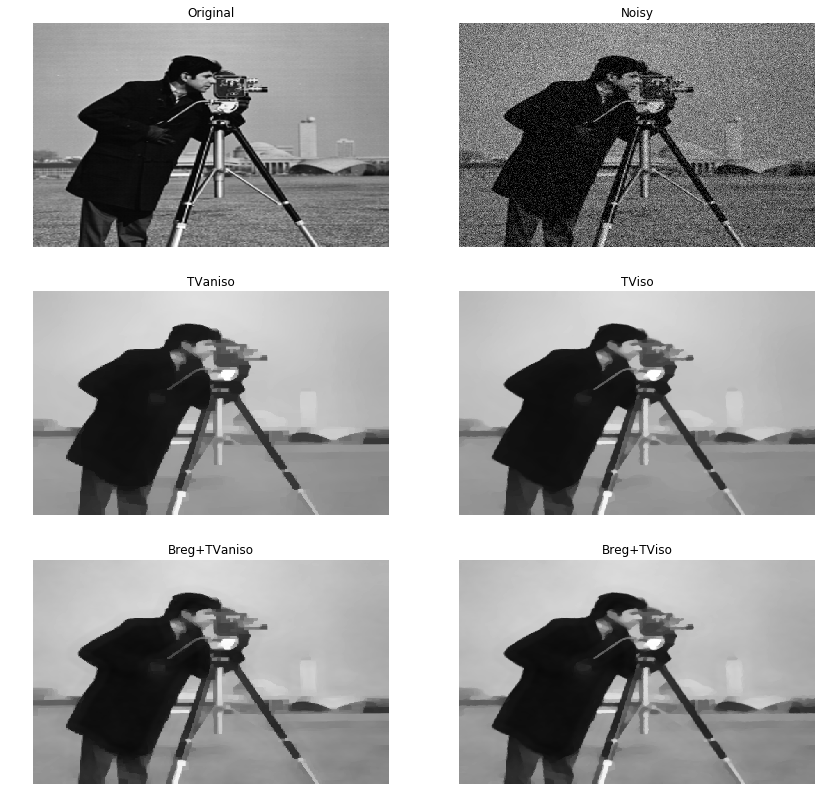

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs[0][0].imshow(img/img.max(), cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img/noise_img.max(), cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml1/iml1.max(), cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('TVaniso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12/iml12.max(), cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');
axs[2][0].imshow(iml1b/iml1b.max(), cmap='gray', vmin=0, vmax=1)
axs[2][0].set_title('Breg+TVaniso')
axs[2][0].axis('off')
axs[2][0].axis('tight')
axs[2][1].imshow(iml12b/iml12b.max(), cmap='gray', vmin=0, vmax=1)
axs[2][1].set_title('Breg+TViso')
axs[2][1].axis('off')
axs[2][1].axis('tight');

## Adaptive PD

In [12]:
def callback(x, f, g, K, cost):
    cost.append(f(x) + g(K.matvec(x)))

In [13]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 20
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

In [18]:
# L2 data term
lamda = .04
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 0.95 / np.sqrt(L)
mu = 0.95 / np.sqrt(L)

cost_fixed = []
iml12_fixed = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                         x0=np.zeros_like(img.ravel()), gfirst=False,
                         niter=300, show=True, callback=lambda x: callback(x, l2, l1iso, Gop, cost_fixed))
iml12_fixed = iml12_fixed.reshape(img.shape)

cost_ada = []
iml12_ada, steps = AdaptivePrimalDual(l2, l1iso, Gop, tau=tau, mu=mu,
                                      x0=np.zeros_like(img.ravel()), niter=45, show=True, tol=0.05,
                                      callback=lambda x: callback(x, l2, l1iso, Gop, cost_ada))
iml12_ada = iml12_ada.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.358757e-01	mu = 3.358757e-01
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.35175e+00   9.316e+07   1.279e+05   0.000e+00       9.329e+07
     2   4.45262e+00   9.076e+07   1.351e+05   0.000e+00       9.090e+07
     3   6.40607e+00   8.845e+07   1.219e+05   0.000e+00       8.857e+07
     4   8.29906e+00   8.620e+07   1.151e+05   0.000e+00       8.631e+07
     5   1.01687e+01   8.400e+07   1.171e+05   0.000e+00       8.412e+07
     6   1.20184e+01   8.186e+07   1.226e+05   0.000e+00       8.198e+07
     7   1.38408e+01   7.977e+07   1.290e+05   0.000e+00       7.990e+07
     8   1.56328e+01   7.774e+07   1

In [19]:
# Error norm comparision
print(np.linalg.norm(img.ravel()-iml12_fixed.ravel()), np.linalg.norm(img.ravel()-iml12_ada.ravel()))

4081.559201707896 4059.567708412816


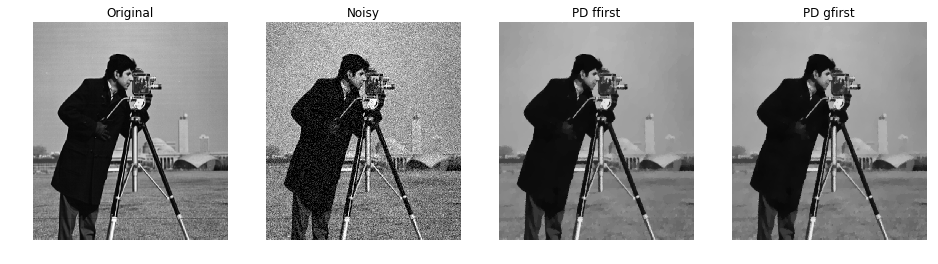

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml12_fixed, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('PD')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(iml12_ada, cmap='gray', vmin=0, vmax=255)
axs[3].set_title('Adaptive PD')
axs[3].axis('off')
axs[3].axis('tight');

Adaptive Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau0 = 3.358757e-01	mu0 = 3.358757e-01
alpha0 = 5.000000e-01	eta = 9.500000e-01
s = 1.000000e+00	delta = 1.500000e+00	niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     2   2.35175e+00   9.316e+07   1.279e+05   0.000e+00       9.329e+07
     3   6.49852e+00   8.846e+07   1.606e+05   0.000e+00       8.862e+07
     4   1.37756e+01   8.028e+07   2.095e+05   0.000e+00       8.049e+07
     5   2.58816e+01   6.757e+07   3.043e+05   0.000e+00       6.787e+07
     6   4.40701e+01   5.056e+07   4.420e+05   0.000e+00       5.100e+07
     7   6.79805e+01   3.198e+07   6.114e+05   0.000e+00       3.259e+07
     8   8.65953e+01   2.054e+07 

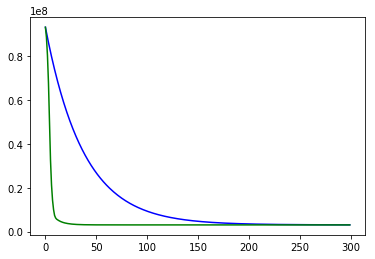

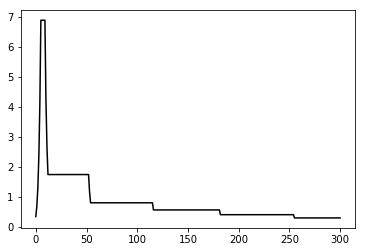

In [23]:
plt.figure()
plt.plot(cost_fixed, 'b')
plt.plot(cost_ada, 'g')

plt.figure()
plt.plot(steps[0], 'k');